In [1]:
# system tools
import warnings
import json
import sys
import string
import ast
import logging

# data cleaning + analysis tools
import pandas as pd
import datetime as dt
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

#nlp tools
import lda #Latent Dirichlet Allocation (create topics)
import gensim
import spacy
from gensim import corpora, models #for constructing document term matrix
#from stop_words import get_stop_words
from gensim.models import Phrases
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams

#set notebook preferences
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


##  Import data frame from cleaning/preprocessing

In [2]:
data = pd.read_csv('data.csv')
data['final_mash'] = data['final_mash'].apply(lambda x:  ast.literal_eval(x))
data['mash'] = data['mash'].apply(lambda x:  ast.literal_eval(x))
data['common_bigrams'] = data['common_bigrams'].apply(lambda x:  ast.literal_eval(x))
data['token'] = data['token'].apply(lambda x:  ast.literal_eval(x))
data['lemma'] = data['lemma'].apply(lambda x:  ast.literal_eval(x))

In [209]:
data.head()

,index,Summary,city,month_year,token_sp,pn,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash,ave
0,0,We are working with an engineering firm on an upcoming project They have asked us to gather maps for this project Would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have Something just showing the route of the water lines would do\n\nth ST NE to nd Ave NE Arlington Cascade Surveying Engineering \n\nI have attached the scope for your convenience Please let me know if you have questions,Arlington,2018-06,We are working with an engineering firm on an upcoming project They have asked us to gather maps for this project Would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have Something just showing the route of the water lines would do\n\nth ST NE to nd Ave NE Arlington Cascade Surveying Engineering \n\nI have attached the scope for your convenience Please let me know if you have questions,"[ave, ne, arlington, cascade, surveying, engineering]",we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne arlington cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, mapsrecords, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, to, nd, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (mapsrecords, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (to, TO), (nd, VB), (cascade, JJ), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (questions, NNS)]","[work, engineering, firm, upcoming, project, ask, u, gather, map, project, would, able, assist, gather, mapsrecords, build, underground, water, facility, may, something, show, route, water, line, would, th, st, nd, cascade, survey, engineering, attach, scope, convenience, please, let, know, question]",39,"[work_engineering, engineering_firm, firm_upcoming, upcoming_project, project_ask, ask_u, u_gather, gather_map, map_project, project_would, would_able, able_assist, assist_gather, gather_mapsrecords, mapsrecords_build, build_underground, underground_water, water_facility, facility_may, may_something, something_show, show_route, route_water, water_line, line_would, would_th, th_st, st_nd, nd_cascade, cascade_survey, survey_engineering, engineering_attach, attach_scope, scope_convenience, convenience_please, please_let, let_know, know_question]",[],"[work, engineering, firm, upcoming, project, gather, map, project, assist, gather, mapsrecords, build, underground, water, facil

In [310]:
# distribution of final mash lengths as baseline

data.mash_len.describe()

count    89324.000000
mean        12.826474
std         24.095661
min          1.000000
25%          2.000000
50%          6.000000
75%         15.000000
max       2472.000000
Name: mash_len, dtype: float64

In [9]:
# produce dictionary with frequency of all words in final mash to use for thresholds

fm_list = [y for x in list(data['final_mash']) for y in x]
counts = Counter(fm_list)

In [23]:
counts.most_common(10)

[('property', 13058),
 ('number', 11451),
 ('incident', 10264),
 ('police', 9587),
 ('permit', 9376),
 ('accident', 9038),
 ('address', 8436),
 ('department', 8347),
 ('location', 7985),
 ('email', 7463)]

In [22]:
# calculate distribution of word count 
count_df = pd.Series(counts, name = 'count') 
count_df.index.name = 'word'
count_df = count_df.reset_index()
count_df['count'].describe()

count    40196.000000
mean        29.150463
std        251.991662
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      13058.000000
Name: count, dtype: float64

### Functions to analyze model performance

In [ ]:
def highest_topic(fp):
    df = pd.read_csv(fp)
    df['topic_comp'] =  df['topic_comp'].apply(lambda x:  ast.literal_eval(x))
    df['comp_len'] = df['topic_comp'].apply(len)
    df = df[df['comp_len'] > 0]
    df['top_topic'] = df['topic_comp'].apply(lambda x: max(x, key=lambda item:item[1])[0])
    df['top_topic_comp'] = df['topic_comp'].apply(lambda x: max(x, key=lambda item:item[1])[1])
    
    return df

def topics_to_csv(df, num_topics):
    for topic in range(0, num_topics):
        subset = df[df['top_topic'] == topic]
        file_name = 'topics/{}_PRR_topic_{}.csv'.format(num_topics, topic)
        subset.to_csv(file_name)

## First, we determine the optimal number of passes and topics for analysis

To identify a baseline number of topics to start from, we look at the 10 cities that publish some sort of categorization with the PRR. In most cases, this is the department that the PRR was routed to for response. Though a department is not necessarily analagous to a topic, this can provide a useful starting point for our analysis.

In [27]:
city_list = ['Bainbridge', 'LasCruces', 'FortCollins', 'Mercer', 'Nola', 'Oakland', 'PaloAlto', 'Redmond', 
             'SanFrancisco', 'Vallejo']
total = 0
for city in city_list:
    filepath = '/Users/alenastern/Google Drive File Stream/My Drive/Alena_Project/PR_Data/{}.csv'.format(city)
    df = pd.read_csv(filepath)
    df = df.dropna(subset=['Dept'])
    df['dpt_list'] = df['Dept'].str.split(';')
    dept_list = [y for x in list(df['dpt_list']) for y in x]
    dpt_set = set(dept_list)
    print(len(dpt_set))
    total += len(dpt_set)

print(total/len(city_list))
    

10
40
37
17
115
73
15
227
10
25
56.9


We see a significant range in the number of topics cities use when they categorize their own data by department, but the average is 57 departments. We'll therefore use 60 as our baseline number of topics.

In [3]:
# Create dictionary and corpus from cleaned data for analysis

texts = list(data['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

We test the combination of several different numbers of topics (centering on 60) and passes to first identify the optimal number of passes. The ideal number of passes is the minimum number of passes at which the nearly all of the documents converge at the end of the number of passes. This strikes the proper balance between model quality and efficiency (as the higher the number of passes, the more time each model takes to run)


In [4]:
num_topics_list = [40, 60, 80]
num_passes_list = [20, 40, 60]
for n in num_topics_list:
    for p in num_passes_list:
   
        # Set up log to external log file
        log_file = 'logs/lda_model_{}_{}.log'.format(n, p)
        logging.basicConfig(filename= log_file, format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)


        lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=n, id2word = dictionary, 
                                             passes = p, random_state=7, eval_every = 5)

        model_name = "lda_{}_{}_model".format(n, p)
        lda.save(model_name)
        corpus_lda = lda[corpus]
        corpus_lda_list = list(corpus_lda)
        topics = data.copy()
        topics = topics.assign(topic_comp = corpus_lda_list)
        file_name = "topics/lda_{}_{}_topics.csv".format(n, p)
        topics.to_csv(file_name)

KeyboardInterrupt: 

We see that the 20 pass option has nearly all of the documents in each chunk converge, while the 40 pass option has all of the documents converge. Therefore we use 30 passes to make sure the documents will converge but avoiding excess passes to increase the time of our testing.

In [ ]:
# We test different numbers of topics and 30 passes to identify the number of topics that yields the best results:
 
num_topics_list = [20, 30, 40, 50, 55, 60, 65, 70, 80]
for n in num_topics_list:
    lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=n, id2word = dictionary, 
                                         passes = 30, random_state=7)
    
    model_name = "lda_{}_30_model".format(n)
    lda.save(model_name)
    corpus_lda = lda[corpus]
    corpus_lda_list = list(corpus_lda)
    topics = data.copy()
    topics = topics.assign(topic_comp = corpus_lda_list)
    file_name = "topics/lda_{}_30_topics.csv".format(n)
    topics.to_csv(file_name)
    

In [4]:
lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
    
model_name = "lda_60_30_model"
lda.save(model_name)
corpus_lda = lda[corpus]
corpus_lda_list = list(corpus_lda)
topics = data.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_60_30_topics.csv"
topics.to_csv(file_name)

In [5]:
final_model = gensim.models.ldamodel.LdaModel.load('lda_60_30_model')
final_model.show_topics(num_topics=60, formatted=False)

[(0,
  [('letter', 0.09737549),
   ('communication', 0.093455285),
   ('correspondence', 0.08368736),
   ('email', 0.069632255),
   ('limited', 0.060233984),
   ('documentation', 0.058903128),
   ('form', 0.048268627),
   ('period', 0.033304118),
   ('official', 0.02801319),
   ('electronic', 0.026774943)]),
 (1,
  [('subcontractor', 0.1035794),
   ('cd', 0.067948595),
   ('update', 0.056225896),
   ('avondale', 0.05379066),
   ('close', 0.050888896),
   ('animal', 0.037690345),
   ('picture', 0.036542214),
   ('exclude', 0.029632203),
   ('geotechnical', 0.023900187),
   ('village', 0.022369672)]),
 (2,
  [('cost', 0.0360035),
   ('section', 0.03540753),
   ('bid', 0.02677816),
   ('pay', 0.02605406),
   ('amount', 0.022230323),
   ('following', 0.020322695),
   ('act', 0.019396419),
   ('government', 0.019075986),
   ('time', 0.01785439),
   ('require', 0.016672151)]),
 (3,
  [('notice', 0.16474165),
   ('body', 0.08646261),
   ('cam', 0.05418779),
   ('sec', 0.050940704),
   ('turn'

Looking at the results of our models, we find that the 60 topic model produces the most coherent results. We therefore use 60 topics for the rest of our model training. However, we still see some issues with the topics. Namely, we see that a considerable number PRRs that contain only a rare proper name (that was not included in our dictionary of proper names) were included in the training set, weakening our model results. We test a number of additional screening criteria for PRRs to include in our training set to see if they improve performance. Overall, we are looking for the criteria that provides the best model results while including the largest number of observations in the training set.

## 1) Remove words at or below certain count

### count = 1

In [113]:
data1 = data.copy()
data1['mash'] = data1['mash'].apply(lambda x: [i for i in x if counts[i] > 10])
data1['final_mash'] = data1['mash'] + data1['common_bigrams']

In [114]:
data1['mash_len'] = data1['final_mash'].apply(len)
data1 = data1[data1['mash_len'] != 0]

In [115]:
data1.mash_len.describe()

count    92563.000000
mean        14.872476
std         26.004775
min          1.000000
25%          3.000000
50%          7.000000
75%         17.000000
max       2411.000000
Name: mash_len, dtype: float64

### count = 10

In [284]:
data.city.unique()

array(['Arlington', 'Asheville', 'Bainbridge', 'Boulder', 'CathedralCity',
       'Clearwater', 'Dayton', 'Denton', 'Everett', 'FortCollins',
       'Greensboro', 'Hayward', 'Kirkland', 'LasCruces', 'Lynnwood',
       'Mercer', 'Miami', 'Middleborough', 'Nola', 'Oakland', 'OKC',
       'Olympia', 'PaloAlto', 'Peoria', 'Pullman', 'RanchoCucamonga',
       'Redmond', 'Renton', 'Sacramento', 'SanFrancisco', 'Tukwila',
       'Vallejo', 'WestSacramento', 'Winchester'], dtype=object)

In [110]:
data10 = data.copy()
data10['mash'] = data10['mash'].apply(lambda x: [i for i in x if counts[i] > 10])
data10['final_mash'] = data10['mash'] + data10['common_bigrams']

In [112]:
data10 = data10[data10['mash_len'] != 0]
data10['mash_len'] = data10['final_mash'].apply(len)
data10.mash_len.describe()

count    93744.000000
mean        14.685111
std         25.893634
min          0.000000
25%          3.000000
50%          7.000000
75%         17.000000
max       2411.000000
Name: mash_len, dtype: float64

## 3) Drop cities with low (less than 4) average count - Asheville, Greensboro, Dayton, OKC

In [89]:
data_lg_cities = data.copy()

In [90]:
data_lg_cities = data_lg_cities[(data['city'] != 'Asheville') & (data['city'] != 'Greensboro') & 
                               (data['city'] != 'Dayton') & (data['city'] != 'OKC')]

## 4) Remove observations with small number of words in final mash 

### 4a) Greater than 2

In [91]:
data_4a = data.copy()
data_4a = data_4a[data_4a['mash_len'] > 2]

#### 4a.1) Model 1a

In [116]:
data_4a1 = data1.copy()
data_4a1 = data_4a1[data_4a1['mash_len'] > 2]

#### 4a.2) Model 1b

In [117]:
data_4a2 = data10.copy()
data_4a2 = data_4a2[data_4a2['mash_len'] > 2]

#### 4a.3) Model 2a

In [94]:
data_4a3 = data_sp2.copy()
data_4a3 = data_4a3[data_4a3['mash_len'] > 2]

#### 4a.4) Model 2b

In [95]:
data_4a4 = data_pn_nltk2.copy()
data_4a4 = data_4a4[data_4a4['mash_len'] > 2]

#### 4a.5) Model 3

In [96]:
data_4a5 = data_lg_cities.copy()
data_4a5 = data_4a5[data_4a5['mash_len'] > 2]

### 4b) Less than 3

In [99]:
data_4b = data.copy()
data_4b = data_4b[data_4b['mash_len'] > 3]

#### 4b.1) Model 1a

In [118]:
data_4b1 = data1.copy()
data_4b1 = data_4b1[data_4b1['mash_len'] > 3]

#### 4b.2) Model 1b

In [119]:
data_4b2 = data10.copy()
data_4b2 = data_4b2[data_4b2['mash_len'] > 3]

#### 4b.3) Model 2a

In [102]:
data_4b3 = data_sp2.copy()
data_4b3 = data_4b3[data_4b3['mash_len'] > 3]

#### 4b.4) Model 2b

In [103]:
data_4b4 = data_pn_nltk2.copy()
data_4b4 = data_4b4[data_4b4['mash_len'] > 3]

#### 4b.5) Model 3

In [104]:
data_4b5 = data_lg_cities.copy()
data_4b5 = data_4b5[data_4b5['mash_len'] > 3]

## Run all LDA models

In [105]:
# Model 1a - words count > 1

texts = list(data1['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data1 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data1"
lda_data1.save(model_name)
corpus_lda = lda_data1[corpus]
corpus_lda_list = list(corpus_lda)
topics = data1.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data1.csv"
topics.to_csv(file_name)



In [106]:
# Model 1b - words count > 10

texts = list(data10['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data10 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data10"
lda_data10.save(model_name)
corpus_lda = lda_data10[corpus]
corpus_lda_list = list(corpus_lda)
topics = data10.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data10.csv"
topics.to_csv(file_name)

# Model 2a

texts = list(data_pn_nltk2['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_nltk = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_nltk"
lda_data_nltk.save(model_name)
corpus_lda = lda_data_nltk[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_pn_nltk2.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_nltk.csv"
topics.to_csv(file_name)


# Model 2b

texts = list(data_sp2['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_sp = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_sp"
lda_data_sp.save(model_name)
corpus_lda = lda_data_nltk[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_sp2.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_sp.csv"
topics.to_csv(file_name)


KeyboardInterrupt: 

In [120]:
# Model 3

texts = list(data_lg_cities['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_lg_cities = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_lg_cities"
lda_data_lg_cities.save(model_name)
corpus_lda = lda_data_lg_cities[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_lg_cities.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_lg_cities.csv"
topics.to_csv(file_name)


# Model 4a

texts = list(data_4a['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4a = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4a"
lda_data_4a.save(model_name)
corpus_lda = lda_data_4a[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4a.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4a.csv"
topics.to_csv(file_name)

# Model 4a1

texts = list(data_4a1['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4a1 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4a1"
lda_data_4a1.save(model_name)
corpus_lda = lda_data_4a1[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4a1.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4a1.csv"
topics.to_csv(file_name)

# Model 4a2

texts = list(data_4a2['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4a2 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_42a"
lda_data_4a2.save(model_name)
corpus_lda = lda_data_4a2[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4a2.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4a2.csv"
topics.to_csv(file_name)

# Model 4a3

texts = list(data_4a3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4a3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4a3"
lda_data_4a3.save(model_name)
corpus_lda = lda_data_4a3[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4a3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4a3.csv"
topics.to_csv(file_name)

# Model 4a4

texts = list(data_4a4['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4a4 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4a4"
lda_data_4a4.save(model_name)
corpus_lda = lda_data_4a4[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4a4.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4a4.csv"
topics.to_csv(file_name)

# Model 4a5

texts = list(data_4a5['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4a5 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4a5"
lda_data_4a5.save(model_name)
corpus_lda = lda_data_4a5[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4a5.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4a5.csv"
topics.to_csv(file_name)

# Model 4b

texts = list(data_4b['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4b = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4b"
lda_data_4b.save(model_name)
corpus_lda = lda_data_4b[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4b.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4b.csv"
topics.to_csv(file_name)

# Model 4b1

texts = list(data_4b1['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4b1 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4b1"
lda_data_4b1.save(model_name)
corpus_lda = lda_data_4b1[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4b1.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4b1.csv"
topics.to_csv(file_name)

# Model 4b2

texts = list(data_4b2['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4b2 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4b2"
lda_data_4b2.save(model_name)
corpus_lda = lda_data_4b2[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4b2.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4b2.csv"
topics.to_csv(file_name)

# Model 4b3

texts = list(data_4b3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4b3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4b3"
lda_data_4b3.save(model_name)
corpus_lda = lda_data_4b3[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4b3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4b3.csv"
topics.to_csv(file_name)

# Model 4b4

texts = list(data_4b4['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4b4 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4b4"
lda_data_4b4.save(model_name)
corpus_lda = lda_data_4b4[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4b4.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4b4.csv"
topics.to_csv(file_name)

# Model 4b5

texts = list(data_4b5['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_4b5 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_4b5"
lda_data_4b5.save(model_name)
corpus_lda = lda_data_4b5[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_4b5.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_4b5.csv"
topics.to_csv(file_name)

KeyboardInterrupt: 

## Model 5 - Proper Nouns with low count 

### 5a) (count = 1)

In [215]:
data_pn = data.copy()

In [216]:
# Create proper noun counter

pn_list = [y for x in list(data_pn['pn']) for y in x]
pn_counts = Counter(pn_list)

In [294]:
# Create counter

fm_list = [y for x in list(data['final_mash']) for y in x]
fm_counts = Counter(fm_list)

In [218]:
words = list(fm_counts.keys())
cnt = list(fm_counts.values())
fm_count_df = pd.DataFrame({'word': words, 'cnt': cnt})

In [219]:
words = list(pn_counts.keys())
cnt = list(pn_counts.values())
pn_count_df = pd.DataFrame({'word': words, 'cnt': cnt})

In [220]:
fm_count_df.cnt.describe()

count    52961.000000
mean        24.413682
std        245.567045
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      15963.000000
Name: cnt, dtype: float64

In [221]:
pn_count_df.cnt.describe()

count    44321.000000
mean        15.447057
std        187.316492
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      14872.000000
Name: cnt, dtype: float64

In [222]:
pn_count_df.sort_values(by = ['cnt'], inplace = True)

In [223]:
data_pn['pn1'] = data_pn['pn'].apply(lambda x: [i for i in x if 0 < fm_counts[i] < 2])

In [224]:
data_pn['pn1_len'] = data_pn['pn1'].apply(len)

In [225]:
data_pn['final_mash'] = data_pn.apply(lambda row: [i for i in row['final_mash'] if i not in row['pn1']], axis =1)
data_pn['mash_len'] = data_pn['final_mash'].apply(len)
data_pn = data_pn[data_pn['mash_len'] > 0]

In [226]:
data_pn[:20]

,index,Summary,city,month_year,token_sp,pn,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash,ave,pn1,pn1_len
0,0,We are working with an engineering firm on an upcoming project They have asked us to gather maps for this project Would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have Something just showing the route of the water lines would do\n\nth ST NE to nd Ave NE Arlington Cascade Surveying Engineering \n\nI have attached the scope for your convenience Please let me know if you have questions,Arlington,2018-06,We are working with an engineering firm on an upcoming project They have asked us to gather maps for this project Would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have Something just showing the route of the water lines would do\n\nth ST NE to nd Ave NE Arlington Cascade Surveying Engineering \n\nI have attached the scope for your convenience Please let me know if you have questions,"[ave, ne, arlington, cascade, surveying, engineering]",we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne arlington cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, mapsrecords, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, to, nd, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (mapsrecords, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (to, TO), (nd, VB), (cascade, JJ), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (questions, NNS)]","[work, engineering, firm, upcoming, project, gather, map, project, assist, gather, mapsrecords, build, underground, water, facility, something, show, route, water, line, cascade, survey, engineering, scope, convenience]",25,"[work_engineering, engineering_firm, firm_upcoming, upcoming_project, project_ask, ask_u, u_gather, gather_map, map_project, project_would, would_able, able_assist, assist_gather, gather_mapsrecords, mapsrecords_build, build_underground, underground_water, water_facility, facility_may, may_something, something_show, show_route, route_water, water_line, line_would, would_th, th_st, st_nd, nd_cascade, cascade_survey, survey_engineering, engineering_attach, attach_scope, scope_convenience, convenience_please, please_let, let_know, know_question]",[],"[work, engineering, firm, upcoming, project, gather, map, project, assist, gather, mapsrecords, build, underground, water, facility, something, show, route, water, line, cascade, survey, engineering

### 5a) (count < 4)

In [227]:
data_pn4 = data.copy()

In [228]:
data_pn4['pn4'] = data_pn4['pn'].apply(lambda x: [i for i in x if 0 < fm_counts[i] < 4])

In [229]:
data_pn4['final_mash'] = data_pn4.apply(lambda row: [i for i in row['final_mash'] if i not in row['pn4']], axis =1)
data_pn4['mash_len'] = data_pn4['final_mash'].apply(len)
data_pn4 = data_pn4[data_pn4['mash_len'] > 0]

In [230]:
data_pn4.shape

(89617, 16)

In [231]:
data_pn4_3 = data_pn4[data_pn4['mash_len'] > 3]

In [232]:
data_pn4_3.shape

(61723, 16)

In [240]:
data_pn4['count_total'] = data_pn4['final_mash'].apply(lambda x: sum(fm_counts[i] for i in x))

## 6) Either short length or high count

In [6]:
data_c = data.copy()

In [19]:
data_c.mash_len.describe()

count    89145.000000
mean        13.144114
std         24.484836
min          1.000000
25%          3.000000
50%          6.000000
75%         15.000000
max       2512.000000
Name: mash_len, dtype: float64

In [10]:
data_c['count_total'] = data_c['final_mash'].apply(lambda x: sum(counts[i] for i in x))

In [25]:
data_c.count_total.describe()

count    8.914500e+04
mean     2.901487e+04
std      4.119699e+04
min      1.000000e+00
25%      5.490000e+03
50%      1.604800e+04
75%      3.546400e+04
max      1.763482e+06
Name: count_total, dtype: float64

In [236]:
#data_c100_3 = data_c[(data_c['mash_len'] > 3) | (data_c['count_total'] > 100)]

In [11]:
data_c2000_3 = data_c[(data_c['mash_len'] > 3) | (data_c['count_total'] > 2000)]

In [27]:
data_c1000_3 = data_c[(data_c['mash_len'] > 3) | (data_c['count_total'] > 1000)]

In [241]:
data_c1000_3_count4 = data_pn4[(data_pn4['mash_len'] > 3) | (data_pn4['count_total'] > 1000)]

In [38]:
data_c1000_3.mash_len.describe()

count    82954.000000
mean        14.020988
std         25.162419
min          1.000000
25%          3.000000
50%          7.000000
75%         16.000000
max       2512.000000
Name: mash_len, dtype: float64

In [39]:
data_c2000_3.mash_len.describe()

count    79909.000000
mean        14.491472
std         25.519064
min          1.000000
25%          3.000000
50%          8.000000
75%         17.000000
max       2512.000000
Name: mash_len, dtype: float64

In [242]:
### Run Models

## 5a

texts = list(data_pn['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_pn = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_pn"
lda_data_pn.save(model_name)
corpus_lda = lda_data_pn[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_pn.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_pn.csv"
topics.to_csv(file_name)

## 5b

texts = list(data_pn4['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_pn4 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_pn4"
lda_data_pn4.save(model_name)
corpus_lda = lda_data_pn4[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_pn4.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_pn4.csv"
topics.to_csv(file_name)


In [28]:
num_list = [40, 50, 60]

In [29]:
## 1000 threshold

texts = list(data_c1000_3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for n in num_list:
    lda_data_c1000_3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=n, id2word = dictionary, 
                                             passes = 30, random_state=7)
    model_name = "lda_data_c1000_3_{}".format(n)
    lda_data_c1000_3.save(model_name)
    corpus_lda = lda_data_c1000_3[corpus]
    corpus_lda_list = list(corpus_lda)
    topics = data_c1000_3.copy()
    topics = topics.assign(topic_comp = corpus_lda_list)
    file_name = "topics/lda_data_c1000_3_{}.csv".format(n)
    topics.to_csv(file_name)


## 2000 threshold

texts = list(data_c2000_3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for n in num_list:

    lda_data_c2000_3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=n, id2word = dictionary, 
                                             passes = 30, random_state=7)
    model_name = "lda_data_c2000_3_{}".format(n)
    lda_data_c2000_3.save(model_name)
    corpus_lda = lda_data_c2000_3[corpus]
    corpus_lda_list = list(corpus_lda)
    topics = data_c2000_3.copy()
    topics = topics.assign(topic_comp = corpus_lda_list)
    file_name = "topics/lda_data_c2000_3_{}.csv".format(n)
    topics.to_csv(file_name)

In [282]:

## 2000 threshold

texts = list(data_c2000_3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_c2000_3_2 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 60, random_state=7)
model_name = "lda_data_c2000_3_2"
lda_data_c2000_3_2.save(model_name)
corpus_lda = lda_data_c2000_3_2[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_c2000_3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_c2000_3_2.csv"
topics.to_csv(file_name)

In [283]:
lda_data_c2000_3_2 = gensim.models.ldamodel.LdaModel.load('lda_data_c2000_3_2')
lda_data_c2000_3_2.show_topics(num_topics=60, formatted=False)

[(0,
  [('ref', 0.12964335),
   ('since', 0.12633274),
   ('child', 0.05254812),
   ('exceed', 0.05003827),
   ('housing', 0.046684396),
   ('family', 0.046582364),
   ('relevant', 0.034656283),
   ('investigate', 0.030152533),
   ('signal', 0.026070984),
   ('abuse', 0.023894273)]),
 (1,
  [('job', 0.04036155),
   ('doc', 0.034017622),
   ('live', 0.03323585),
   ('association', 0.027101738),
   ('son', 0.025491267),
   ('description', 0.02513783),
   ('daughter', 0.024561983),
   ('create', 0.022989985),
   ('receipt', 0.02265158),
   ('miss', 0.02187046)]),
 (2,
  [('intersection', 0.07643916),
   ('steal', 0.069572784),
   ('info', 0.04923086),
   ('medical', 0.043133166),
   ('view', 0.036689773),
   ('tell', 0.03656593),
   ('foot', 0.021272397),
   ('directly', 0.019169154),
   ('procurement', 0.017022246),
   ('evaluation', 0.0156686)]),
 (3,
  [('traffic', 0.17774299),
   ('client', 0.10486326),
   ('related', 0.057885926),
   ('tpd', 0.051455863),
   ('assist', 0.0406475),
  

## 7) Calculate avg count per word

In [30]:
data_avg = data_c1000_3.copy()

In [31]:
data_avg['avg_count'] = data_avg['count_total']/ data_avg['mash_len']

In [322]:
data_avg.avg_count.describe()

count    81994.000000
mean      2798.577090
std       1959.209709
min          1.000000
25%       1410.342857
50%       2348.000000
75%       3544.828125
max      12989.000000
Name: avg_count, dtype: float64

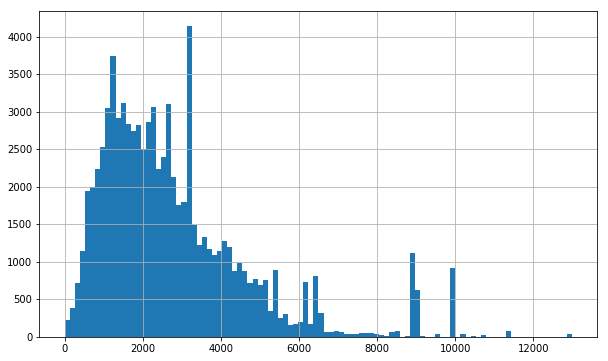

In [323]:
data_c1000_3.avg_count.hist(bins = 100)
plt.show()

In [32]:
data_avg = data_avg[data_avg['avg_count'] > 500]

In [325]:
data_avg.shape

(79737, 18)

In [35]:
texts = list(data_avg['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for n in num_list:

    lda_data_avg_2 = gensim.models.ldamodel.LdaModel(corpus, num_topics=n, id2word = dictionary, 
                                             passes = 20, random_state=7)
    model_name = "lda_data_avg_2_{}".format(n)
    lda_data_avg_2.save(model_name)
    corpus_lda = lda_data_avg_2[corpus]
    corpus_lda_list = list(corpus_lda)
    topics = data_avg.copy()
    topics = topics.assign(topic_comp = corpus_lda_list)
    file_name = "topics/lda_data_avg_2_{}.csv".format(n)
    topics.to_csv(file_name)

## 8) Remove all words on surnames or first names list

In [155]:
def name_list(st, end, thresh):
    names = set()
    for yr in range(st, end+1):
        fp = '../data/names/yob{}.txt'.format(yr)
        df = pd.read_table(fp, sep = ',', names = ['name', 'sex', 'count'])
        df = df[df['count'] >= thresh]
        #df['name'] = df['name'].str.lower()
        names |= set(df['name'])
    
    return list(names)
        

In [148]:
names = name_list(1950,2017)

In [174]:
 df = pd.read_table('../data/names/yob2000.txt', sep = ',', names = ['name', 'sex', 'count'])

In [175]:
df['count'].describe()

count    29769.000000
mean       126.913198
std        940.286427
min          5.000000
25%          6.000000
50%         11.000000
75%         28.000000
max      34471.000000
Name: count, dtype: float64

In [145]:
last_names = pd.read_csv('../data/names/surnames.csv')
#last_names['name'] = last_names['name'].str.lower()
#last_names = last_names[last_names['count'] > 200]
ln = set(last_names['name'])

In [178]:
last_names['count'].describe()

count    1.516710e+05
mean     1.596357e+03
std      1.633875e+04
min      1.000000e+02
25%      1.430000e+02
50%      2.370000e+02
75%      5.510000e+02
max      2.376206e+06
Name: count, dtype: float64

In [149]:
all_names = names + ln

In [153]:
data8 = data.copy()

In [162]:
data8['final_mash'] = data8['final_mash'].apply(lambda x: [i for i in x if i not in all_names])

In [163]:
data8.to_csv('data8.csv')

In [165]:
data8[:50]

,index,Summary,city,month_year,token_sp,pn,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash,ave
0,0,We are working with an engineering firm on an upcoming project They have asked us to gather maps for this project Would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have Something just showing the route of the water lines would do\n\nth ST NE to nd Ave NE Arlington Cascade Surveying Engineering \n\nI have attached the scope for your convenience Please let me know if you have questions,Arlington,2018-06,We are working with an engineering firm on an upcoming project They have asked us to gather maps for this project Would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have Something just showing the route of the water lines would do\n\nth ST NE to nd Ave NE Arlington Cascade Surveying Engineering \n\nI have attached the scope for your convenience Please let me know if you have questions,"[ave, ne, arlington, cascade, surveying, engineering]",we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne arlington cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, mapsrecords, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, ne, to, nd, ave, ne, arlington, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (mapsrecords, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (ne, JJ), (to, TO), (nd, VB), (ave, VB), (ne, JJ), (arlington, NN), (cascade, NN), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have,...","[work, engineering, firm, upcoming, project, gather, map, project, assist, gather, mapsrecords, build, underground, water, facility, something, show, route, water, line, arlington, cascade, survey, engineering, scope, convenience]",26,"['work_engineering', 'engineering_firm', 'firm_upcoming', 'upcoming_project', 'project_ask', 'ask_u', 'u_gather', 'gather_map', 'map_project', 'project_would', 'would_able', 'able_assist', 'assist_gather', 'gather_mapsrecords', 'mapsrecords_build', 'build_underground', 'underground_water', 'water_facility', 'facility_may', 'may_something', 'something_show', 'show_route', 'route_water', 'water_line', 'line_would', 'would_th', 'th_st', 'st_ne', 'ne_nd', 'nd_ave', 'ave_ne', 'ne_arlington', 'arlington_cascade', 'cascade_survey', 'survey_engineering', 'engineering_attach', 'attach_scope', 'scope_convenience', 'convenience_please', 'please_let', 'let_know', 'know_question']",[],"[engineering, upcomi

In [167]:
"show" in all_names

True

In [3]:
final_model = gensim.models.ldamodel.LdaModel.load('lda_data_avg_2')
final_model.show_topics(num_topics=60, formatted=False)

[(0,
  [('release', 0.06310156),
   ('message', 0.053707477),
   ('dept', 0.038750865),
   ('email', 0.035141557),
   ('fill', 0.034113996),
   ('attachment', 0.032544743),
   ('intend', 0.024758236),
   ('agent', 0.022754971),
   ('appreciated', 0.018765239),
   ('ext', 0.018348742)]),
 (1,
  [('email', 0.1818666),
   ('send', 0.15561295),
   ('correspondence', 0.07502094),
   ('staff', 0.03861128),
   ('design', 0.023777582),
   ('resident', 0.022963252),
   ('via', 0.021026168),
   ('many', 0.018914051),
   ('agree', 0.018585507),
   ('internal', 0.01812959)]),
 (2,
  [('present', 0.2790568),
   ('commission', 0.0582687),
   ('hold', 0.052094877),
   ('comment', 0.039434116),
   ('station', 0.028819256),
   ('cell', 0.024763783),
   ('son', 0.023494402),
   ('put', 0.022321556),
   ('article', 0.022137297),
   ('offender', 0.018125655)]),
 (3,
  [('applicant', 0.08370827),
   ('doc', 0.042680804),
   ('waiver', 0.027276946),
   ('assistant', 0.023932833),
   ('position', 0.021351948

In [5]:
def highest_topic(fp):
    df = pd.read_csv(fp)
    df['topic_comp'] =  df['topic_comp'].apply(lambda x:  ast.literal_eval(x))
    df['comp_len'] = df['topic_comp'].apply(len)
    df = df[df['comp_len'] > 0]
    df['top_topic'] = df['topic_comp'].apply(lambda x: max(x, key=lambda item:item[1])[0])
    df['top_topic_comp'] = df['topic_comp'].apply(lambda x: max(x, key=lambda item:item[1])[1])
    
    return df

In [6]:
def topics_to_csv(df, num_topics):
    for topic in range(0, num_topics):
        subset = df[df['top_topic'] == topic]
        file_name = 'topics/{}_PRR_topic_{}.csv'.format(num_topics, topic)
        subset.to_csv(file_name)

In [36]:
fp = "topics/lda_data_avg_2_40.csv"
final_model = gensim.models.ldamodel.LdaModel.load('lda_data_avg_2_40')
final_model.show_topics(num_topics=40, formatted=False)


[(0,
  [('accident', 0.33520052),
   ('accident_report', 0.13667019),
   ('auto', 0.08008845),
   ('auto_accident', 0.057890106),
   ('demand', 0.035833027),
   ('domestic', 0.027195599),
   ('violence', 0.021416098),
   ('involve', 0.020288344),
   ('location', 0.01923843),
   ('pedestrian', 0.014613737)]),
 (1,
  [('number', 0.21572885),
   ('license', 0.101398855),
   ('associate', 0.066614054),
   ('driver', 0.055639893),
   ('floor', 0.02804665),
   ('approved', 0.02722742),
   ('background', 0.024994612),
   ('picture', 0.018693095),
   ('background_check', 0.017108785),
   ('southport', 0.014999265)]),
 (2,
  [('next', 0.032952346),
   ('company', 0.032222018),
   ('family', 0.030279987),
   ('residential', 0.029060848),
   ('tell', 0.026525185),
   ('many', 0.024030048),
   ('electronically', 0.02105616),
   ('spreadsheet', 0.020498956),
   ('gang', 0.018541565),
   ('category', 0.016800022)]),
 (3,
  [('collision', 0.11474114),
   ('traffic', 0.084924735),
   ('collision_repor

In [37]:
df = highest_topic(fp)
topics_to_csv(df, 40)

In [12]:
texts = list(data_c2000_3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_c2000_3_60 = gensim.models.ldamodel.LdaModel.load('lda_data_c2000_3_60')
corpus_lda = lda_data_c2000_3_60[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_c2000_3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_c2000_3_60_2.csv"
topics.to_csv(file_name)

In [ ]:
df = highest_topic('topics/lda_data_c2000_3_60.csv')
topics_to_csv(df, 60)